# ЛР7 — Кластеризация (KMeans, DBSCAN, Agglomerative) + PCA
Важно: `Attrition_Flag` **не используем** для обучения кластеризаторов. Используем **только для сравнения** результатов (ARI/NMI) после обучения.

In [1]:
from pathlib import Path

PROJECT_ROOT = Path('..').resolve()
DATA_PATH = PROJECT_ROOT/'data'/'raw'/'BankChurners.csv'
PROJECT_ROOT, DATA_PATH

(PosixPath('/home/decll/Документы/ML-HW/HW3&7'),
 PosixPath('/home/decll/Документы/ML-HW/HW3&7/data/raw/BankChurners.csv'))

## 1. Чтение и очистка данных

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Не найден файл {DATA_PATH}. Скачайте датасет с Kaggle и положите BankChurners.csv в data/raw/"
    )

df_raw = pd.read_csv(DATA_PATH)

df = df_raw.copy()
df = df.drop(columns=["CLIENTNUM"], errors="ignore")
nb_cols = [c for c in df.columns if c.startswith("Naive_Bayes_Classifier") or "Naive_Bayes" in c]
if nb_cols:
    df = df.drop(columns=nb_cols, errors="ignore")

TARGET = "Attrition_Flag"
X = df.drop(columns=[TARGET])
y_true = df[TARGET]

# Для внешних метрик удобнее кодировать метки в числа
le = LabelEncoder()
y_true_enc = le.fit_transform(y_true)

print("X shape:", X.shape)
X.head()

X shape: (10127, 19)


,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## 2. Препроцессинг (OHE + StandardScaler)

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

X_all = preprocessor.fit_transform(X)
X_all.shape

(10127, 37)

## 3. PCA для понижения размерности (визуализация 2D)

In [4]:
import numpy as np
from sklearn.decomposition import PCA

X_dense = X_all.toarray() if hasattr(X_all, "toarray") else X_all
pca2 = PCA(n_components=2, random_state=42)
X_2d = pca2.fit_transform(X_dense)
X_2d.shape

(10127, 2)

## 4. Кластеризация тремя методами

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# 1) KMeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
km_labels = kmeans.fit_predict(X_all)

# 2) DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=10)
db_labels = dbscan.fit_predict(X_all)

# 3) Agglomerative
agg = AgglomerativeClustering(n_clusters=2, linkage="ward")
agg_labels = agg.fit_predict(X_dense)

set(km_labels), set(db_labels), set(agg_labels)

({0, 1}, {-1}, {0, 1})

## 5. Метрики качества кластеризации + сравнение с истинными метками

In [6]:
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def eval_cluster(name, labels):
    labels = np.asarray(labels)
    uniq = sorted(set(labels.tolist()))
    n_noise = int(np.sum(labels == -1)) if -1 in uniq else 0

    # внутренние метрики считаем без шумовых точек DBSCAN (-1), если возможно
    sil = None
    dbi = None
    mask = labels != -1
    uniq_wo_noise = sorted(set(labels[mask].tolist()))
    if len(uniq_wo_noise) >= 2 and mask.sum() > 2:
        sil = float(silhouette_score(X_all[mask], labels[mask]))
        dbi = float(davies_bouldin_score(X_dense[mask], labels[mask]))

    # внешние метрики (сравнение с истинными метками)
    ari = float(adjusted_rand_score(y_true_enc, labels))
    nmi = float(normalized_mutual_info_score(y_true_enc, labels))

    return {
        "algo": name,
        "labels_unique": uniq,
        "n_noise": n_noise,
        "silhouette": sil,
        "davies_bouldin": dbi,
        "ARI": ari,
        "NMI": nmi,
    }

res = pd.DataFrame([
    eval_cluster("KMeans", km_labels),
    eval_cluster("DBSCAN", db_labels),
    eval_cluster("Agglomerative", agg_labels),
])
res

,algo,labels_unique,n_noise,silhouette,davies_bouldin,ARI,NMI
0,KMeans,"[0, 1]",0,0.157329,2.300252,-0.015618,0.000915
1,DBSCAN,[-1],10127,NaN,NaN,0.000000,0.000000
2,Agglomerative,"[0, 1]",0,0.167826,2.383111,-0.045024,0.007500


## 6. Визуализация (PCA-2D): кластеры и истинные метки

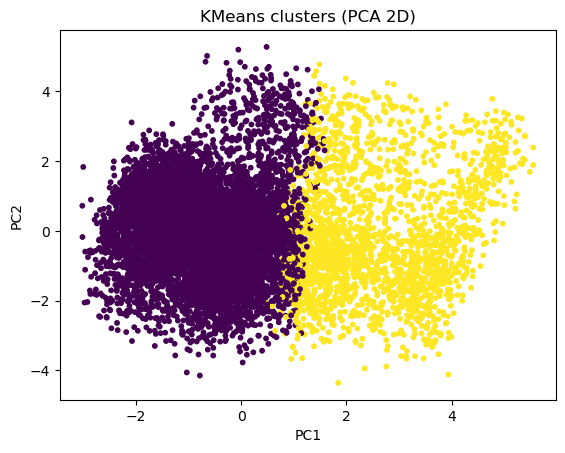

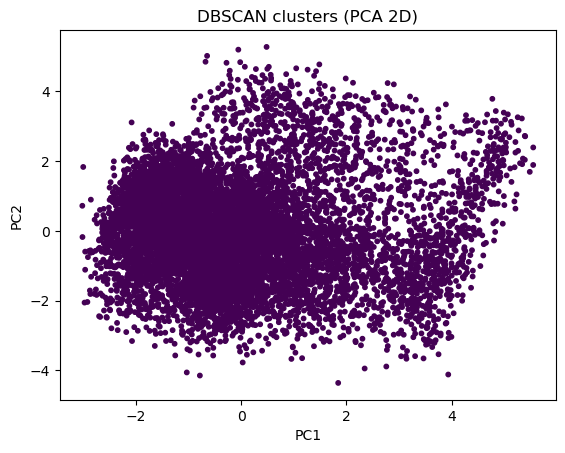

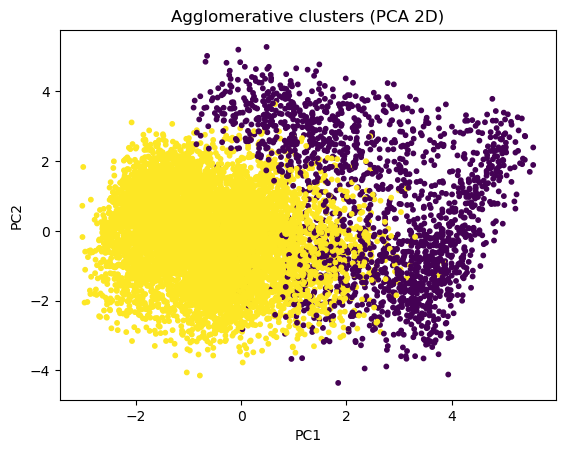

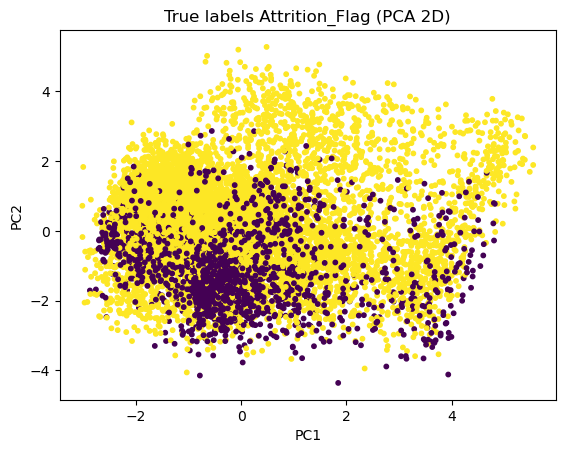

In [7]:
import matplotlib.pyplot as plt

def plot_scatter(labels, title):
    plt.figure()
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=10)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

plot_scatter(km_labels, "KMeans clusters (PCA 2D)")
plot_scatter(db_labels, "DBSCAN clusters (PCA 2D)")
plot_scatter(agg_labels, "Agglomerative clusters (PCA 2D)")

plot_scatter(y_true_enc, "True labels Attrition_Flag (PCA 2D)")

## 7. Выводы
В проекции данных на первые две главные компоненты (PCA) не наблюдается чётко разделённых кластеров: точки сильно перекрываются, а истинные метки оттока не образуют выраженных групп. По внутренним метрикам лучшим оказался Agglomerative clustering (silhouette ≈ 0.17), немного превосходя KMeans (≈ 0.16), однако значения Davies–Bouldin остаются высокими, что говорит о слабой разделимости кластеров. Совпадение кластеров с истинными метками крайне низкое: значения ARI и NMI близки к нулю или отрицательны, что означает отсутствие связи между кластерами и классами. Это объясняется тем, что методы обучения без учителя не используют целевую переменную, а отток клиентов не соответствует простой геометрической структуре в пространстве признаков. Алгоритм DBSCAN не смог выделить кластеры и отнёс все объекты к шуму (label = -1), что показывает его чувствительность к параметрам и плохую применимость к данному датасету. В целом, для данной задачи методы кластеризации без учителя оказываются менее эффективными, чем обучение с учителем.